# Long Catfish Group Project
## Neuromatch Academy 2021

---
Marco Apolinario, marco.apolinario.l@gmail.com

Angus Chapman, afchapman@ucsd.edu

Jason Eshraghian, jasonesh@umich.edu

Rongqi Hong, rongqi.hong2@outlook.com

Aysha Naurein, achuachachu@gmail.com

Raul Rodriguez, raul.rodriguez@berkeley.edu

Taniya Seth, taniyaseth.sau@gmail.com

## Abstract
### **Is traveling down a DNN similar to traveling up the Visual System?**

The visual system consists of hierarchical brain regions that sequentially process visual input to achieve object recognition. While response properties are well understood in early visual regions, responses in later visual regions are sparse and complex, making them difficult to characterize using traditional neuroscientific approaches. Deep Neural Networks (DNNs) trained for visual classification offer potential insight into the processing within these brain regions by providing a framework in which computational hypotheses about the brain can be tested directly. Therefore, to better understand what drives object recognition through different stages of visual processing, we compared the responses in different layers of a DNN to responses in specific regions of the visual cortex. 

Neural responses to 1,750 images, taken from a pre-existing dataset, were recorded from seven brain regions of interest (ROIs) using fMRI. We collected DNN activations corresponding to the same images from eight layers of AlexNet pre-trained on the ImageNet dataset. To compare neural responses with the DNN in a common measurement space, representational dissimilarity matrices (RDMs) for each visual ROI and DNN layer were computed and correlated. We found that early DNN layers correlated most strongly with early regions of visual cortex (V1 & V2), while later DNN layers correlated primarily with intermediate visual regions (lateral occipital cortex) that are more closely related to object recognition. In contrast, when RDMs from an untrained DNN were used, there was no correlation with any visual region. 

Broadly, these findings are consistent with the idea that DNNs process images similarly to the visual cortex, with abstraction increasing along each hierarchy. This suggests that understanding the computations within deeper DNN layers may reveal insights about the representational structure of information at higher levels of the visual system.


# Main analysis code

In [ ]:
# @title Import modules
import glob
import numpy as np
import urllib
import torch
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import torchvision
from torchvision import transforms as trn
import scipy
import scipy.io as sio
import h5py
import os
from PIL import Image
from torch.autograd import Variable as V
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

def loadmat(matfile):
    """Function to load .mat files.
    Parameters
    ----------
    matfile : str
        path to `matfile` containing fMRI data for a given trial.
    Returns
    -------
    dict
        dictionary containing data in key 'vol' for a given trial.
    """
    try:
        f = h5py.File(matfile)
    except (IOError, OSError):
        return sio.loadmat(matfile)
    else:
        return {name: np.transpose(f.get(name)) for name in f.keys()}

NEED TO CHECK IF THESE MODULES ARE ALL NEEDED

## fMRI data

### Load dataset

In [ ]:
fname = "kay_labels.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/r638s/download
fname = "kay_labels_val.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/yqb3e/download
fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

In [ ]:
with np.load(fname) as dobj:
    dat = dict(**dobj)
labels = np.load('kay_labels.npy') # 4 x 1750
val_labels = np.load('kay_labels_val.npy') # 4 x 120
image_list = dat["stimuli"]  # 1750 x 128 x 128

In [ ]:
print('Total Number of Images: ', len(image_list))

Total Number of Images:  1750


### Calculate RDMs for each ROI

In [ ]:
brain_RDMs = []
for roi in range(1,len(dat["roi_names"])): # ignore empty "other" voxels
  
  thisDat = dat["responses"][:,dat["roi"]==roi] # voxel responses
  temp_RDM = 1-np.corrcoef(thisDat)
  temp_RDM[np.triu_indices(temp_RDM.shape[0],1)] = np.nan # get lower triangle
  brain_RDMs.append(temp_RDM)

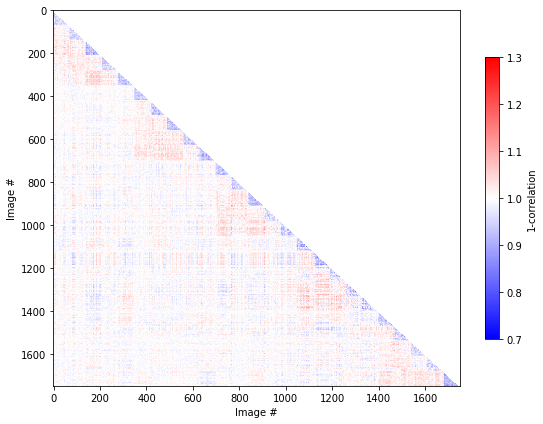

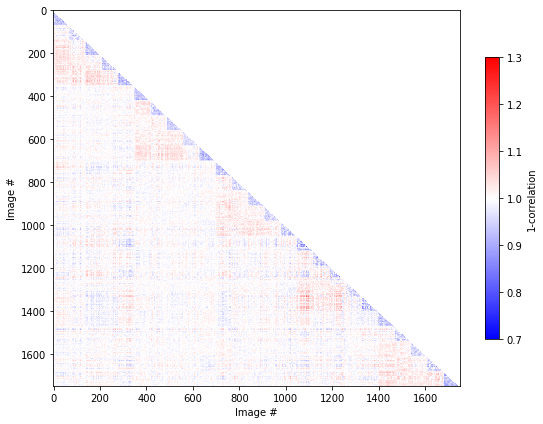

In [ ]:
# dissimilarity matrix of V1
f, ax = plt.subplots(figsize=(8, 6))
ax.set(xlabel="Image #", ylabel="Image #")
heatmap = ax.imshow(brain_RDMs[0], aspect="auto", vmin=0.7, vmax=1.3, cmap="bwr")
f.colorbar(heatmap, shrink=.75, label="1-correlation")
f.tight_layout()

# dissimilarity matrix of LOC
f, ax = plt.subplots(figsize=(8, 6))
ax.set(xlabel="Image #", ylabel="Image #")
heatmap = ax.imshow(brain_RDMs[6], aspect="auto", vmin=0.7, vmax=1.3, cmap="bwr")
f.colorbar(heatmap, shrink=.75, label="1-correlation")
f.tight_layout()

### Correlate RDMs over ROIs

In [ ]:
# preallocate a correlation matrix
cor_ROIs = np.empty((len(brain_RDMs),len(brain_RDMs)))
cor_ROIs[:] = np.nan

# loop over ROIs
for i in range(len(brain_RDMs)):
  for j in range(i,len(brain_RDMs)):
    RDM_1 = brain_RDMs[i][np.tril_indices(brain_RDMs[i].shape[0],-1)]
    RDM_2 = brain_RDMs[j][np.tril_indices(brain_RDMs[j].shape[0],-1)]

    cor_ROIs[j,i] = np.corrcoef(RDM_1, RDM_2)[0,1]

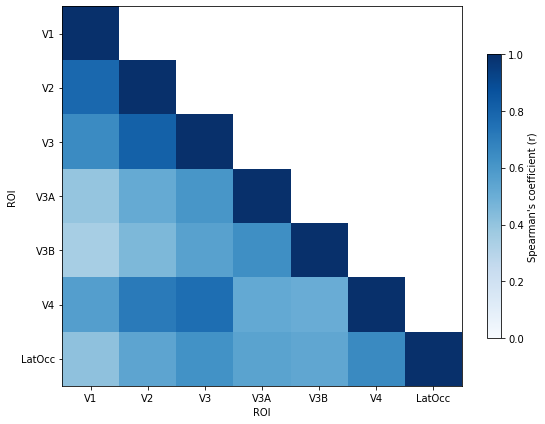

In [ ]:
# correlation matrix of RDMs across ROIs
f, ax = plt.subplots(figsize=(8, 6))
ax.set(xlabel="ROI", ylabel="ROI", xticklabels = dat["roi_names"], yticklabels = dat["roi_names"])
heatmap = ax.imshow(cor_ROIs, aspect="auto", vmin=0, vmax=1, cmap="Blues")
f.colorbar(heatmap, shrink=.75, label="Spearman's coefficient (r)")
f.tight_layout()

As we would expect, there is a greater correlation between ROIs that are closer together in the visual hierarchy (V1, V2, & V3, e.g.) than between regions that are further apart (V1 & LOC, e.g.)

## DNN Model

In [ ]:
# @title Define Model Architecture
__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

# Here we redefine AlexNet differently from torchvision code for better understanding
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.fc6 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            )
        self.fc7 =nn.Sequential(
            nn.Dropout(),
            nn.Linear(4096, 4096),
            )
        self.fc8 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            )

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        out3 = self.conv3(out2)
        out4 = self.conv4(out3)
        out5 = self.conv5(out4)

        out5_reshaped = out5.view(out5.size(0), 256 * 6 * 6)
        out6= self.fc6(out5_reshaped)
        out7= self.fc7(out6)
        out8 = self.fc8(out7)
        return out1, out2, out3,out4, out5, out6,out7,out8


def alexnet(pretrained=False, **kwargs):
    """AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
    return model


def load_alexnet(model_checkpoints):
    """This function initializes an Alexnet and load
    its weights from a pretrained model. Since we redefined model in a different
    way we have to rename the weights that were in the pretrained checkpoint.
    ----------
    model_checkpoints : str
        model checkpoints location.
    Returns
    -------
    model
        pytorch model of alexnet
    """

    model = alexnet()
    # Load checkpoint
    model_file = model_checkpoints
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)

    # Rename the checkpoint keys according to new definition
    model_dict =["conv1.0.weight", "conv1.0.bias", "conv2.0.weight", "conv2.0.bias", "conv3.0.weight", "conv3.0.bias", "conv4.0.weight", "conv4.0.bias", "conv5.0.weight", "conv5.0.bias", "fc6.1.weight", "fc6.1.bias", "fc7.1.weight", "fc7.1.bias", "fc8.1.weight", "fc8.1.bias"]
    state_dict={}
    i=0
    for k,v in checkpoint.items():
        state_dict[model_dict[i]] =  v
        i+=1

    # initialize model with pretrained weights 
    model.load_state_dict(state_dict)
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    return model

In [ ]:
def get_activations_and_save(model, image_list, activations_dir):
    resize_normalize = trn.Compose([
            trn.Resize((224,224)),
            trn.ToTensor(),
            trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # for all images in the list generate and save activations
    for image_file in tqdm(range(1750)):  # 1750 x 3 x 128 x 128

        tmp = np.zeros((128, 128, 3))
        tmp[:,:,0] = image_list[image_file]
        tmp[:,:,1] = image_list[image_file]
        tmp[:,:,2] = image_list[image_file]

        img_repeat = tmp  # 128 x 128 x 3
        
        img = Image.fromarray(((img_repeat-img_repeat.min())/(img_repeat.max()-img_repeat.min())*255).astype(np.uint8))
        
        image_file_name = "{0}".format(time.time_ns())

        input_img = V(resize_normalize(img).unsqueeze(0))
        x = model.forward(input_img)

        activations = []
        for i,feat in enumerate(x):
            activations.append(feat.data.cpu().numpy().ravel())

        for layer in range(len(activations)):
            save_path = os.path.join(activations_dir, image_file_name+"_"+"layer" + "_" + str(layer+1) + ".npy")
            np.save(save_path,activations[layer])

In [ ]:
## Get activations from AlexNet
save_dir = "/content/activations_alexnet"

# load Alexnet initialized with pretrained weights
checkpoint_path = "/content/alexnet.pth"
if not os.path.exists(checkpoint_path):
    url = "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"
    urllib.request.urlretrieve(url, "/content/alexnet.pth")
model = load_alexnet(checkpoint_path)

# get and save activations
activations_dir = os.path.join(save_dir)
if not os.path.exists(activations_dir):
    os.makedirs(activations_dir)
print("-------------Saving activations ----------------------------")
temp = get_activations_and_save(model, image_list, activations_dir)


  0%|          | 2/1750 [00:00<01:53, 15.42it/s]

-------------Saving activations ----------------------------



100%|██████████| 1750/1750 [01:55<00:00, 15.18it/s]


In [ ]:
## Load activations
num_layers = 8  # number of layers in the model
layers = []

for i in range(num_layers):
  layers.append("layer" + "_" + str(i+1))

model_activations = {}
# create RDM for each layer from activations
for layer in layers:
  activation_files =  glob.glob(activations_dir + '/*'+layer + '.npy')
  activation_files.sort()
  activations = []
  # Load all activations
  for activation_file  in activation_files:
    activations.append(np.load(activation_file))
  activations = np.array(activations)
  model_activations[layer] = activations

### Calculate RDMs for each model layer

In [ ]:
## create RDM for each layer from activations
model_RDMs = {}
for layer in layers:
  # calculate Pearson's distance for all pairwise comparisons
  activations = model_activations[layer]

  # clear out non-responsive units
  activations = activations[:,np.std(activations,axis=0)>0]
  # activationZ = scipy.stats.zscore(activations, axis=0) # z-scores

  temp_RDM = 1-np.corrcoef(activations)
  temp_RDM[np.triu_indices(temp_RDM.shape[0], 1)] = np.nan
  model_RDMs[layer] = temp_RDM

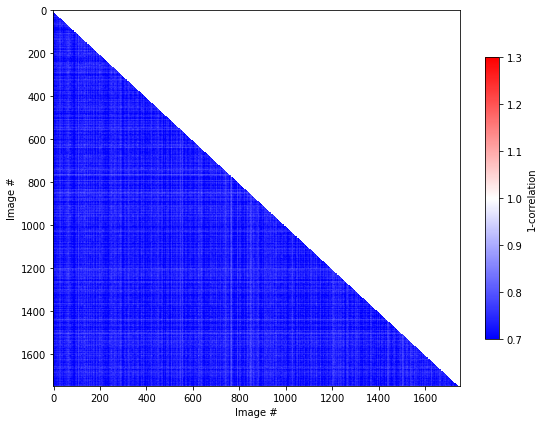

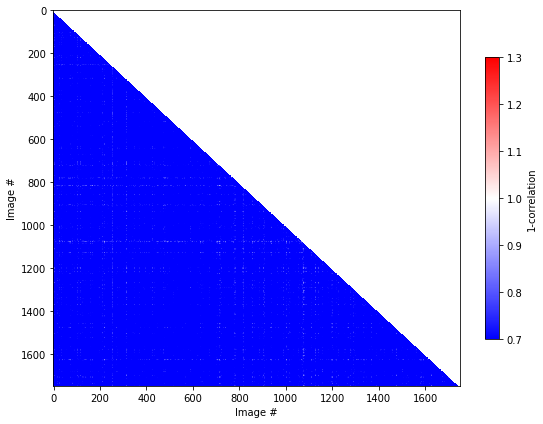

In [ ]:
## dissimilarity matrix of AlexNet first convolutional layer
f, ax = plt.subplots(figsize=(8, 6))
ax.set(xlabel="Image #", ylabel="Image #")
heatmap = ax.imshow(model_RDMs["layer_1"], vmin=0.7, vmax=1.3, aspect="auto", cmap="bwr")
f.colorbar(heatmap, shrink=.75, label="1-correlation")
f.tight_layout()

## dissimilarity matrix of AlexNet final fully-connected layer
f, ax = plt.subplots(figsize=(8, 6))
ax.set(xlabel="Image #", ylabel="Image #")
heatmap = ax.imshow(model_RDMs["layer_8"], vmin=0.7, vmax=1.3, aspect="auto", cmap="bwr")
f.colorbar(heatmap, shrink=.75, label="1-correlation")
f.tight_layout()

### Correlate RDMs over layers

In [ ]:
# preallocate a correlation matrix
cor_layer = np.empty((len(model_RDMs),len(model_RDMs)))
cor_layer[:] = np.nan

# loop over ROIs
for i in range(len(layers)):
  for j in range(i,len(layers)):
    RDM_1 = model_RDMs[layers[i]][np.tril_indices(model_RDMs[layers[i]].shape[0],-1)]
    RDM_2 = model_RDMs[layers[j]][np.tril_indices(model_RDMs[layers[j]].shape[0],-1)]

    cor_layer[j,i] = np.corrcoef(RDM_1, RDM_2)[0,1]

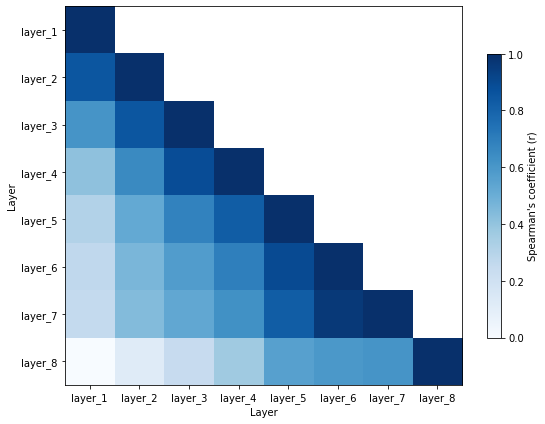

In [ ]:
# correlation matrix of RDMs across layers
f, ax = plt.subplots(figsize=(8, 6))
ax.set(xlabel="Layer", ylabel="Layer", xticklabels = [0]+layers, yticklabels = [0]+layers)
heatmap = ax.imshow(cor_layer, aspect="auto", vmin=0, vmax=1, cmap="Blues")
f.colorbar(heatmap, shrink=.75, label="Spearman's coefficient (r)")
f.tight_layout()

As for the brain data, the correlations are higher between layers that are closer together in the network hierarchy. However, there is a more uniform relationship between the RDMs as you go up the hierarchy when compared to the brain ROIs.

## Comparison between brain and DNN responses

### Correlate ROIs with layers

In [ ]:
# preallocate a correlation matrix
cor_list_comp = np.empty((len(brain_RDMs),len(model_RDMs)))
cor_list_comp[:] = np.nan

# loop over ROIs
for i in range(len(brain_RDMs)):
  for j in range(len(model_RDMs)):
    RDM_1 = brain_RDMs[i][np.tril_indices(brain_RDMs[i].shape[0],-1)]
    RDM_2 = model_RDMs[layers[j]][np.tril_indices(model_RDMs[layers[j]].shape[0],-1)]

    cor_list_comp[i,j] = np.corrcoef(RDM_1, RDM_2)[0,1]

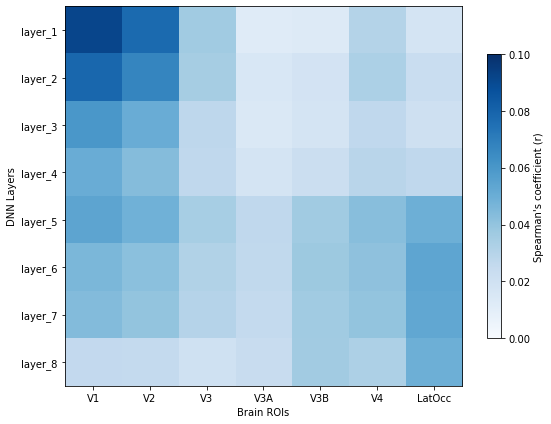

In [ ]:
# correlation matrix of RDMs
f, ax = plt.subplots(figsize=(8, 6))
ax.set(xlabel="Brain ROIs", ylabel="DNN Layers", xticklabels = dat["roi_names"], yticklabels = [0]+layers)
heatmap = ax.imshow(cor_list_comp.T, aspect="auto", vmin=0, vmax=0.1, cmap="Blues")
f.colorbar(heatmap, shrink=.75, label="Spearman's coefficient (r)")
f.tight_layout()

The strongest correlations are between the early visual regions (V1 & V2) and the earliest AlexNet layers (layers 1 & 2). Elsewhere, the correlations are mostly weak, if present at all, however there is a slight relationship between Lateral Occipital Cortex responses and the responses of the later layers of AlexNet (layers 5-8).

# Supplementary analyses

## Untrained DNN

To confirm that the correlations between the brain and DNN RDMs are due to true shared representations, we performed a similar analysis but this time used a DNN that had not been trained.

### Get network activations

In [ ]:
## get and save activations
untrained_model = alexnet(pretrained=False)

save_dir = "/content/activations_untrained_alexnet"

activations_dir = os.path.join(save_dir)
if not os.path.exists(activations_dir):
    os.makedirs(activations_dir)
print("-------------Saving activations ----------------------------")
get_activations_and_save(untrained_model, image_list, activations_dir)


  0%|          | 2/1750 [00:00<02:20, 12.48it/s]

-------------Saving activations ----------------------------



100%|██████████| 1750/1750 [02:04<00:00, 14.11it/s]


### Calculate RDMs for untrained AlexNet

In [ ]:
## Load activations
activations_dir = "activations_untrained_alexnet"
num_layers = 8  # number of layers in the model
layers = []

for i in range(num_layers):
  layers.append("layer" + "_" + str(i+1))

untrained_RDMs = {}
# create RDM for each layer from activations
for layer in layers:
  activation_files =  glob.glob(activations_dir + '/*'+layer + '.npy')
  activation_files.sort()
  activations = []
  # Load all activations
  for activation_file  in activation_files:
    activations.append(np.load(activation_file))
  activations = np.array(activations)

  # calculate Pearson's distance for all pairwise comparisons 
  untrained_RDMs[layer] = 1-np.corrcoef(activations)

### Correlate between brain and untrained DNN

In [ ]:
# preallocate a correlation matrix
cor_list_untr = np.empty((len(brain_RDMs),len(untrained_RDMs)))
cor_list_untr[:] = np.nan

# loop over ROIs
for i in range(len(brain_RDMs)):
  for j in range(len(untrained_RDMs)):
    RDM_1 = brain_RDMs[i][np.tril_indices(brain_RDMs[i].shape[0],-1)]
    RDM_2 = untrained_RDMs[layers[j]][np.tril_indices(untrained_RDMs[layers[j]].shape[0],-1)]

    cor_list_untr[i,j] = np.corrcoef(RDM_1, RDM_2)[0,1]

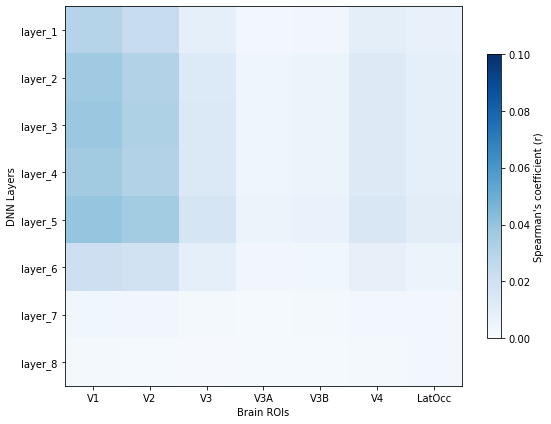

In [ ]:
# correlation matrix of RDMs
f, ax = plt.subplots(figsize=(8, 6))
ax.set(xlabel="Brain ROIs", ylabel="DNN Layers", xticklabels = dat["roi_names"], yticklabels = [0]+layers)
heatmap = ax.imshow(cor_list_untr.T, aspect="auto", vmin=0, vmax=0.1, cmap="Blues")
f.colorbar(heatmap, shrink=.75, label="Spearman's coefficient (r)")
f.tight_layout()

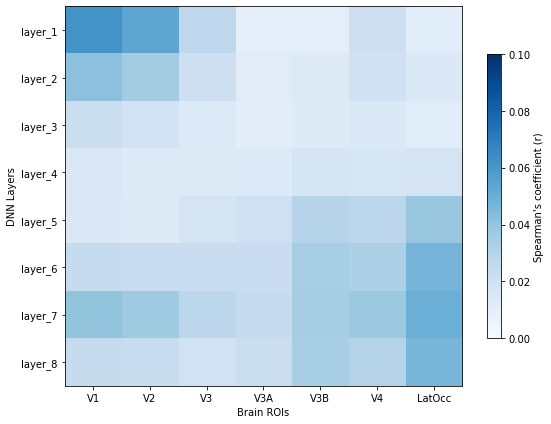

In [ ]:
# difference between trained and untrained AlexNet activations
f, ax = plt.subplots(figsize=(8, 6))
ax.set(xlabel="Brain ROIs", ylabel="DNN Layers", xticklabels = dat["roi_names"], yticklabels = [0]+layers)
heatmap = ax.imshow(cor_list_comp.T - cor_list_untr.T, aspect="auto", vmin=0, vmax=0.1, cmap="Blues")
f.colorbar(heatmap, shrink=.75, label="Spearman's coefficient (r)")
f.tight_layout()

The untrained AlexNet was only weakly correlated with any of the brain ROIs. Comparisons between the trained and untrained models confirmed that early visual regions were most related to early model layers, and LOC was most related to later model layers.

## Alternative DNN Architectures

We also tested whether different model architectures would result in more similar correlations with the brain ROIs. In particular, we focused on the recent VOneNet model, which consists of a manually constructed first layer that is supposedly more similar in structure to early visual cortex. 

See [this Github repository](https://github.com/dicarlolab/vonenet) for more detail on VOneNet.

In [ ]:
# @title Load VOneNet
!pip  install git+https://github.com/dicarlolab/vonenet.git

import vonenet
v1_model = vonenet.get_model(model_arch='alexnet', pretrained=True).module

  Cloning https://github.com/dicarlolab/vonenet.git to /tmp/pip-req-build-q5iwg11k
  Running command git clone -q https://github.com/dicarlolab/vonenet.git /tmp/pip-req-build-q5iwg11k
Neuronal distributions gabor parameters


/usr/local/lib/python3.7/dist-packages/vonenet/params.py:59: RuntimeWarning: invalid value encountered in true_divide
  ny_dist_marg = n_joint_dist / n_joint_dist.sum(axis=1, keepdims=True)


Model:  VOneAlexNet


In [ ]:
## register hooks
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

v1_model.vone_block.register_forward_hook(get_activation('bottleneck'))
v1_model.model.features[2].register_forward_hook(get_activation('conv1'))
v1_model.model.features[4].register_forward_hook(get_activation('conv2'))
v1_model.model.features[6].register_forward_hook(get_activation('conv3'))
v1_model.model.features[9].register_forward_hook(get_activation('conv4'))
v1_model.model.classifier[2].register_forward_hook(get_activation('fc6'))
v1_model.model.classifier[4].register_forward_hook(get_activation('fc7'))
v1_model.model.classifier[6].register_forward_hook(get_activation('fc8'))

In [ ]:
# @title Activation function for VOneNet
def get_activations_and_save_vonenet(model, image_list, activations_dir):
    resize_normalize = trn.Compose([
            trn.Resize((224,224)),
            trn.ToTensor(),
            trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    num_layers = 8  # number of layers in the model
    layers = []

    for i in range(num_layers):
      layers.append("layer" + "_" + str(i+1))

    for image_file in tqdm(range(1750)):  # 1750 x 3 x 128 x 128
        tmp = np.zeros((88, 88, 3))
        tmp[:,:,0] = image_list[image_file][20:108, 20:108]
        tmp[:,:,1] = image_list[image_file][20:108, 20:108]
        tmp[:,:,2] = image_list[image_file][20:108, 20:108]
        img_repeat = tmp  # 128 x 128 x 3
        
        img = Image.fromarray(((img_repeat-img_repeat.min())/(img_repeat.max()-img_repeat.min())*255).astype(np.uint8))
        
        image_file_name = "{0}".format(time.time_ns())

        input_img = V(resize_normalize(img).unsqueeze(0))
        x = model(input_img)

        activations_layer = []
        for k in activation.keys():
            activations_layer.append(activation[k].data.cpu().numpy().ravel())

        for layer in range(num_layers):
            save_path = os.path.join(activations_dir, image_file_name+"_"+"layer" + "_" + str(layer+1) + ".npy")
            np.save(save_path,activations_layer[layer])

In [ ]:
## get and save activations
save_dir = "/content/activations_vonenet"

activations_dir = os.path.join(save_dir)
if not os.path.exists(activations_dir):
    os.makedirs(activations_dir)
print("-------------Saving activations ----------------------------")
get_activations_and_save_vonenet(v1_model, image_list, activations_dir)

  0%|          | 0/1750 [00:00<?, ?it/s]

-------------Saving activations ----------------------------


100%|██████████| 1750/1750 [09:59<00:00,  2.92it/s]


In [ ]:
## Load activations
activations_dir = "activations_vonenet"
num_layers = 8  # number of layers in the model
layers = []

for i in range(num_layers):
  layers.append("layer" + "_" + str(i+1))

vonenet_RDMs = {}
# create RDM for each layer from activations
for layer in layers:
  activation_files =  glob.glob(activations_dir + '/*'+layer + '.npy')
  activation_files.sort()
  activations = []
  activation_files = activation_files
  # Load all activations
  for activation_file  in activation_files:
    activations.append(np.load(activation_file))
  activations = np.array(activations)

  # calculate RDMs
  temp_RDM = 1-np.corrcoef(activations)
  temp_RDM[np.triu_indices(temp_RDM.shape[0], 1)] = np.nan
  vonenet_RDMs[layer] = temp_RDM

### Calculate RDMs for VOneNet

In [ ]:
## create RDM for each layer from activations
vonenet_RDMs = {}
for layer in layers:
  # calculate Pearson's distance for all pairwise comparisons
  activations = vonenet_activations[layer]

  # clear out non-responsive units
  activations = activations[:,np.std(activations,axis=0)>0]

  # print(np.any(np.isnan(activations)))
  temp_RDM = 1-np.corrcoef(activations)
  temp_RDM[np.triu_indices(temp_RDM.shape[0], 1)] = np.nan
  vonenet_RDMs[layer] = temp_RDM

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# preallocate a correlation matrix
cor_vonenet = np.empty((len(vonenet_RDMs),len(vonenet_RDMs)))
cor_vonenet[:] = np.nan

# loop over ROIs
for i in range(len(layers)):
  for j in range(i,len(layers)):
    RDM_1 = vonenet_RDMs[layers[i]][np.tril_indices(vonenet_RDMs[layers[i]].shape[0],-1)]
    RDM_2 = vonenet_RDMs[layers[j]][np.tril_indices(vonenet_RDMs[layers[j]].shape[0],-1)]

    cor_vonenet[j,i] = np.corrcoef(RDM_1, RDM_2)[0,1]

ValueError: ignored

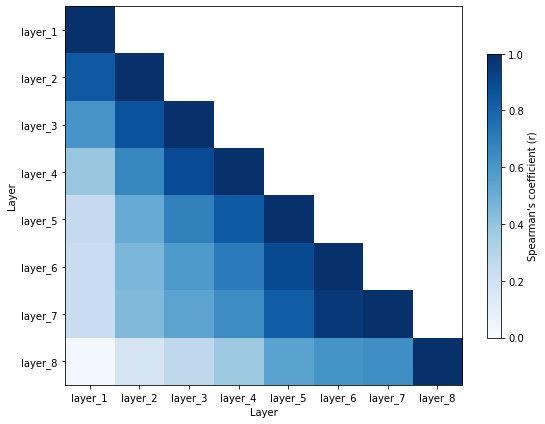

In [ ]:
# correlation matrix of RDMs across layers
f, ax = plt.subplots(figsize=(8, 6))
ax.set(xlabel="Layer", ylabel="Layer", xticklabels = [0]+layers, yticklabels = [0]+layers)
heatmap = ax.imshow(cor_vonenet, aspect="auto", vmin=0, vmax=1, cmap="Blues")
f.colorbar(heatmap, shrink=.75, label="Spearman's coefficient (r)")
f.tight_layout()